# Continuous flow

Below is a very simple example of training a continuous flow on a mixture of two Gaussians.

In [ ]:
import flax.nnx as nnx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# for monitoring
from IPython.display import clear_output
from tqdm import tqdm

# for training
import optax

import bijx

# define a random number sequence for convenience
rngs = nnx.Rngs(0)

In [ ]:
# define a vector field and use automatic computation of the divergence

class VectorFieldBase(nnx.Module):

    def __init__(self, size: int, t_emb: int = 16, hidden=64, depth=2, *, activation=nnx.gelu, rngs):
        # let's assume here the event shape is simply (size,)
        self.size = size
        self.t_emb = t_emb
        self.t_emb_proj = nnx.Linear(1, t_emb, rngs=rngs)
        self.activation = activation
        self.embed = nnx.Linear(size + t_emb, hidden, rngs=rngs)
        self.layers = [nnx.Linear(hidden, hidden, rngs=rngs) for _ in range(depth)]
        self.out = nnx.Linear(hidden, size, rngs=rngs)

    def __call__(self, t, x):
        t_emb = jnp.sin(self.t_emb_proj(jnp.array([t])))
        t_emb = t_emb.reshape((1,) * (x.ndim - 1) + (-1,))
        t_emb = jnp.tile(t_emb, x.shape[:-1] + (1,))
        x = jnp.concatenate([x, t_emb], -1)
        x = self.embed(x)
        for layer in self.layers:
            x += layer(self.activation(x))
        return self.out(x)

In [ ]:
vf = bijx.AutoJacVF(VectorFieldBase(2, rngs=rngs))

In [ ]:
# define flow (integration of vector field)
flow = bijx.ContFlowRK4(vf, t_start=0, t_end=1, steps=15)
# flow = bijx.ContFlowDiffrax(vf, config=bijx.DiffraxConfig(dt=1/10))
prior = bijx.IndependentNormal((2,), rngs=nnx.Rngs(sample=42))
sampler = bijx.Transformed(prior, flow)

In [ ]:
# add noise to parameters to compare something "interesting" below
noise_rngs = nnx.Rngs(12)

graph, params, rest = nnx.split(sampler, nnx.Param, nnx.Variable)
params = jax.tree.map(lambda p: p + 0.1 * jax.random.normal(noise_rngs(), p.shape), params)
sampler_noised = nnx.merge(graph, params, rest)

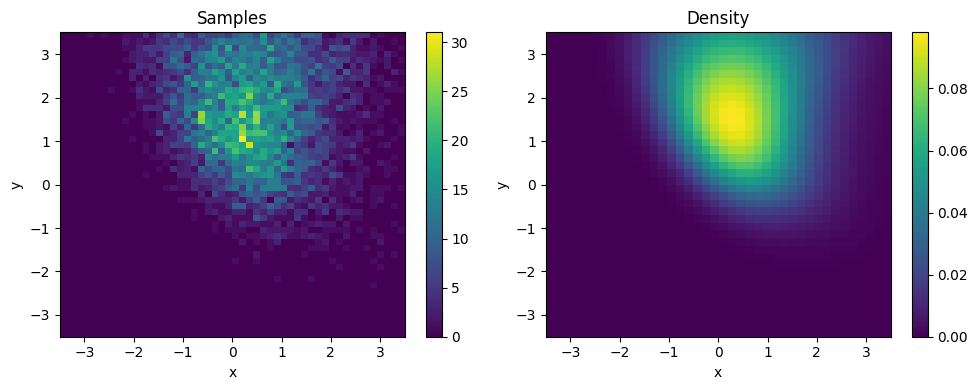

In [ ]:
plt.figure(figsize=(10, 4))

# Sample plot
plt.subplot(1, 2, 1)
x, _ = sampler_noised.sample((10000,))
plt.hist2d(*x.T, bins=50, range=[[-3.5, 3.5], [-3.5, 3.5]])
plt.title("Samples")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.colorbar()

# Density plot
plt.subplot(1, 2, 2)
x, y = np.mgrid[-3.5:3.5:7/40, -3.5:3.5:7/40]
dens = np.exp(sampler_noised.log_density(np.stack([y, x], -1)))
plt.imshow(dens, extent=[-3.5, 3.5, -3.5, 3.5], origin='lower', aspect='auto')
plt.title("Density")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()

plt.tight_layout()
plt.show()

## Training 

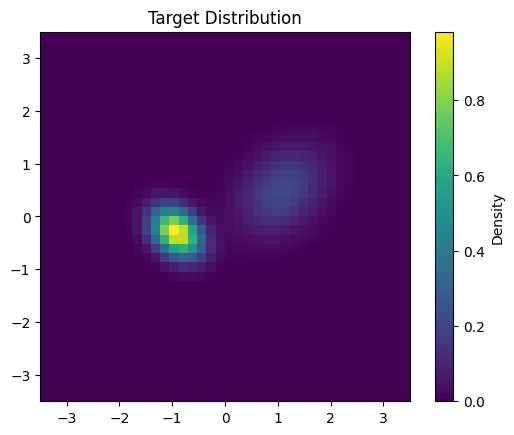

In [ ]:
def target_log_prob(x):
    # Mixture of two Gaussians
    mean1 = jnp.array([1.0, 0.4])
    cov1 = 0.3 * jnp.array([[1.0, 0.3], [0.3, 1.0]])

    mean2 = jnp.array([-1.0, -0.4])
    cov2 = 0.1 * jnp.array([[1.0, -0.3], [-0.3, 1.0]])

    pdf1 = jax.scipy.stats.multivariate_normal.pdf(x, mean1, cov1)
    pdf2 = jax.scipy.stats.multivariate_normal.pdf(x, mean2, cov2)

    return jnp.log(0.4 * pdf1 + 0.6 * pdf2)

# Visualize the target distribution
plt.imshow(
    np.exp(target_log_prob(np.stack([y, x], -1))),
    extent=[-3.5, 3.5, -3.5, 3.5],
    origin='lower'
)
plt.colorbar(label='Density')
plt.title('Target Distribution')
plt.show()

In [ ]:
x, lq = sampler.sample((128,))
lp = target_log_prob(x)

In [ ]:
optimizer = nnx.Optimizer(
    sampler,
    optax.adam(optax.exponential_decay(1e-2, 200, 0.1, end_value=1e-3)),
    wrt=nnx.Param,
)

@nnx.jit
def training_step(sampler, optimizer):
    def _loss(sampler):
        x, lq = sampler.sample((128,))
        lp = target_log_prob(x)
        # reverse KL loss
        return -jnp.mean(lp - lq), bijx.utils.effective_sample_size(lp, lq)

    (dkl, ess), grads = nnx.value_and_grad(_loss, has_aux=True)(sampler)
    optimizer.update(grads=grads, model=sampler)
    return dkl, ess

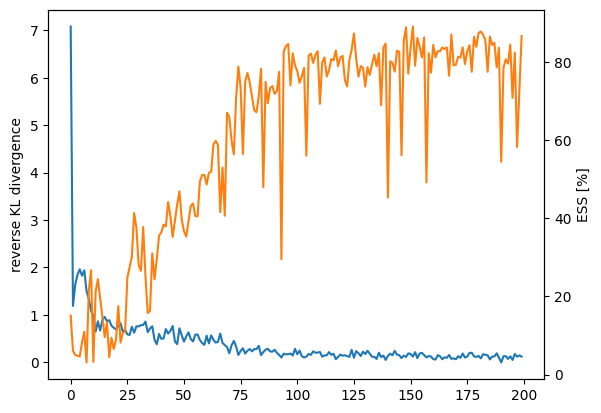

100%|██████████| 200/200 [00:11<00:00, 17.57it/s]


In [ ]:
steps = 200

dkls = np.full(steps, np.nan)
ess = np.full(steps, np.nan)

for i in tqdm(range(steps)):
    dkls[i], ess[i] = training_step(sampler, optimizer)

    if (i + 1) % 10 == 0:
        clear_output(wait=True)

        plt.plot(dkls)
        plt.ylabel('reverse KL divergence')
        plt.twinx()
        plt.plot(100 * ess, color='C1')
        plt.ylabel('ESS [%]')
        plt.show()

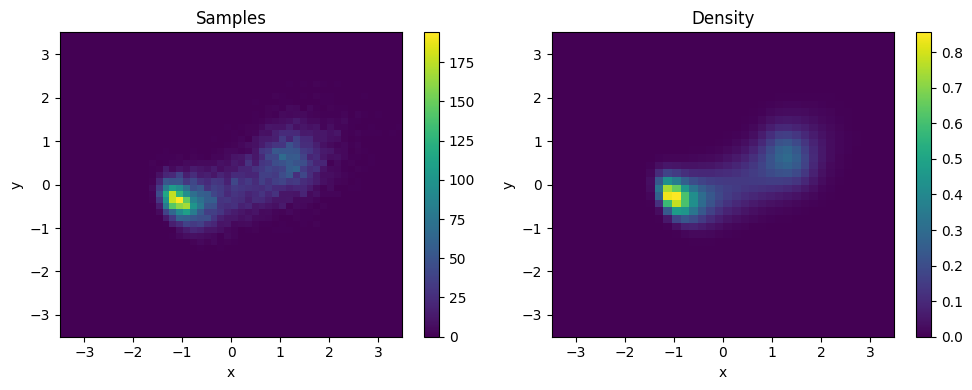

In [ ]:
plt.figure(figsize=(10, 4))

# Sample plot
plt.subplot(1, 2, 1)
x, _ = sampler.sample((10000,))
plt.hist2d(*x.T, bins=50, range=[[-3.5, 3.5], [-3.5, 3.5]])
plt.title("Samples")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.colorbar()

# Density plot
plt.subplot(1, 2, 2)
x, y = np.mgrid[-3.5:3.5:7/40, -3.5:3.5:7/40]
dens = np.exp(sampler.log_density(np.stack([y, x], -1)))
plt.imshow(dens, extent=[-3.5, 3.5, -3.5, 3.5], origin='lower', aspect='auto')
plt.title("Density")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()

plt.tight_layout()
plt.show()